In [40]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import datetime

%load_ext tensorboard

## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [4]:
fashion_mnist = keras.datasets.fashion_mnist

In [5]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

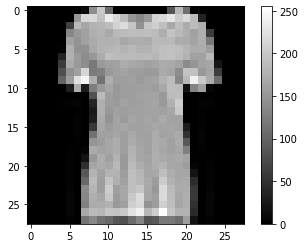

In [6]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [7]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

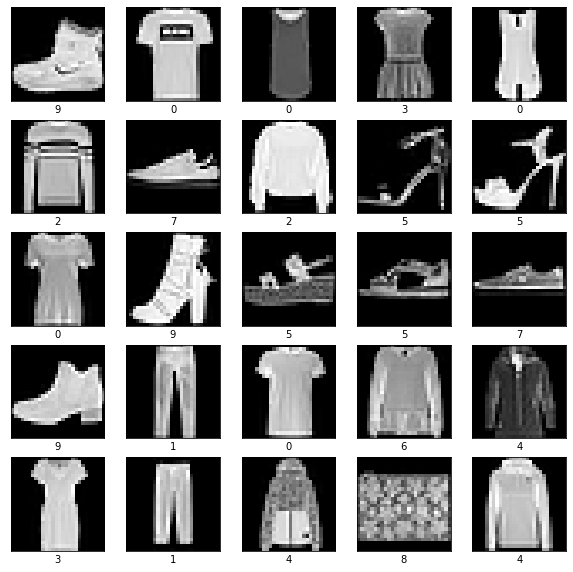

In [8]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

In [9]:

label_dictionary = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

In [246]:
label_dictionary

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

'Pullover'

In [191]:
# First we one hot encode the labels for our training set

enc_train = OneHotEncoder()

enc_train.fit(train_labels.reshape(-1, 1))

onehotlabels_train = enc_train.transform(train_labels.reshape(-1,1)).toarray()

print("train shape:", onehotlabels_train.shape)

# We one hot encode the labels for our test set

enc_test = OneHotEncoder()

enc_test.fit(test_labels.reshape(-1, 1))

onehotlabels_test = enc_test.transform(test_labels.reshape(-1,1)).toarray()

print("test shape:", onehotlabels_test.shape)

train shape: (60000, 10)
test shape: (10000, 10)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you us

In [193]:
# Next we transform our training images into row vectors

x_train = train_images.reshape(-1, 28 * 28)

print(x_train.shape)

# Add bias

x_train = np.insert(x_train, 0, np.ones(len(x_train)), axis=1).astype(np.float32)

print(x_train.shape)

(60000, 784)
(60000, 785)


In [192]:
# Next we transform our test images into row vectors

x_test = test_images.reshape(-1, 28 * 28)

print(x_test.shape)

# Add bias

x_test = np.insert(x_test, 0, np.ones(len(x_test)), axis=1).astype(np.float32)

print(x_test.shape)

(10000, 784)
(10000, 785)


In [242]:
class LogisticRegressionSoftmax:
    def __init__(self, x, labels):
        # vector de weights para logits
        self.w = tf.get_variable("weights", dtype = tf.float32, shape = [x_train.shape[1], labels.shape[1]], initializer = tf.zeros_initializer())
        
    # Funcion para el calculo de logits
    def logits(self, x):
        #with tf.name_scope("logits"):
        return tf.matmul(x, self.w)
    
    def prediction(self, x):
        return tf.nn.softmax(tf.matmul(x, self.w))
    
    def accuracy(self, predictions, labels):
        accuracy = tf.equal(tf.argmax(predictions,1), tf.argmax(labels,1))
        accuracy = tf.dtypes.cast(accuracy, tf.int32)
        accuracy = tf.divide(tf.reduce_sum(accuracy), tf.shape(labels)[0])
        return accuracy
            
    def update(self, x_train, labels_train, x_test, labels_test, learningrate):
        with tf.name_scope("error"):
            train_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels_train, logits = tf.matmul(x_train, self.w)))
            train_error_summary = tf.summary.scalar("TrainError", train_error)
            test_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels_test, logits = tf.matmul(x_test, self.w)))
            test_error_summary = tf.summary.scalar("TestError", test_error)
        with tf.name_scope("accuracy"):
            train_accuracy = self.accuracy(self.prediction(x_train), labels_train)
            train_accuracy_summary = tf.summary.scalar("TrainAccuracy", train_accuracy)
            test_accuracy = self.accuracy(self.prediction(x_test), labels_test)
            test_accuracy_summary = tf.summary.scalar("TestAccuracy", test_accuracy)
        gradient = tf.gradients(train_error, [self.w])
        updated_w = tf.assign(self.w, self.w - learningrate * gradient[0])
        return updated_w, train_error, test_error, train_accuracy, test_accuracy, train_error_summary, test_error_summary, train_accuracy_summary, test_accuracy_summary
    

In [243]:
def training(lr, epochs, frecprint, x_train, x_test, labels_train, labels_test):
    # String para definicion de experimento
    string = './graphs/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S") +"_lr="+str(lr)+ "_epochs="+str(epochs)

    g = tf.Graph()
    with g.as_default():
        # Inicialización de objeto de clase LinearModel
        modelo = LogisticRegressionSoftmax(x_train, onehotlabels_train)
        # Definicion de placeholders para input de data a grafo
        with tf.name_scope("train_tensors"):
            tensor_x_train = tf.placeholder(tf.float32, [None,None], "tensor_x_train")
            tensor_labels_train = tf.placeholder(tf.float32, [None,None], "tensor_labels_train")
        with tf.name_scope("test_tensors"):
            tensor_x_test = tf.placeholder(tf.float32, [None,None], "tensor_x_test")
            tensor_labels_test = tf.placeholder(tf.float32, [None,None], "tensor_labels_test")
        # Utilizacion de método update para hacer el entrenamiento
        update_parameters = modelo.update(tensor_x_train, tensor_labels_train, tensor_x_test, tensor_labels_test, lr)
    
        # Writer para utilizacion de tensorboard
        writer = tf.summary.FileWriter(string, g)
        
        batch_size = 32
        
        total_steps = int((labels_train.shape[0] / batch_size) * epochs)  
        
        with tf.train.MonitoredSession() as session:
            
            for i in range(total_steps + 1):
                offset = (i * batch_size) % (labels_train.shape[0] - batch_size)
                batch_data = x_train[offset:(offset + batch_size),]
                batch_labels = labels_train[offset:(offset + batch_size),]
                feed_dict = {tensor_x_train:batch_data, tensor_labels_train:batch_labels,tensor_x_test:x_test, tensor_labels_test:labels_test}
                # Entrenamiento
                training = session.run(update_parameters, feed_dict = feed_dict)
                if (i)%frecprint == 0:
                    # Cálculo de pesos para print por cada frecprint epocas
                    weights = session.run(modelo.w, feed_dict = feed_dict)
                    # Agregar datos a writer para poder visualizarlos en tensorboard
                    writer.add_summary(training[5], i)
                    writer.add_summary(training[6], i)
                    writer.add_summary(training[7], i)
                    writer.add_summary(training[8], i)
                    print("Batch:", i, "train error:", training[1], "train accuracy:", training[3])
                    print("Epoch:", int(i//(labels_train.shape[0] / batch_size)+1), "test error:", training[2], "test accuracy:", training[4])
                    print("-------------------------------------------------------------------------")
            
            return weights

            writer.close()

In [249]:
output = training(0.1, 10, 10, x_train, x_test, onehotlabels_train, onehotlabels_test)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Batch: 0 train error: 2.3025854 train accuracy: 0.1875
Epoch: 1 test error: 45411.867 test accuracy: 0.1353
-------------------------------------------------------------------------
Batch: 10 train error: 88362.5 train accuracy: 0.4375
Epoch: 1 test error: 93232.16 test accuracy: 0.3932
-------------------------------------------------------------------------
Batch: 20 train error: 17983.793 train accuracy: 0.71875
Epoch: 1 test error: 67862.5 test accuracy: 0.5263
-------------------------------------------------------------------------
Batch: 30 train error: 72756.67 train accuracy: 0.28125
Epoch: 1 test error: 54932.043 test accuracy: 0.4589
-------------------------------------------------------------------------
Batch: 40 train error: 59911.656 train accuracy: 0.3125
Epoch: 1 test error: 68373.26 test accuracy: 0.4369
---------------------------------------------

KeyboardInterrupt: 

In [41]:
%tensorboard --logdir ./graphs --port 6007

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 18960.

In [245]:
%tensorboard --logdir ./graphs --port 6007

Reusing TensorBoard on port 6007 (pid 12960), started 11:01:49 ago. (Use '!kill 12960' to kill it.)